In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score,confusion_matrix
from scipy.stats import chi2_contingency
from scipy.stats import mannwhitneyu
import math
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix

In [3]:
######### 參數設定1 #########
input_type = 1 # 0: xlsx 
               # 1: csv 
               # 2: libsvm檔

header = 0 # 如果有header填0，沒有的話填None
           # 檔案是libsvm檔的話隨便填
    
scale = 1 # 1: 需要scale, 其它:不需要scale

feature_select = 1 # 0: 無, 1: 有

# 如果 feature_select = 1
feature_num = np.array([[9,10 ,13 ,15 ,17 ,18 ,23 ,34 ,35 ,39 ,58 ,61 ,62 ,73 ,89 ]])
#feature_num = np.array([[1,8,10,11,13,19,28,29,30,35,43,53]])
#feature_num = np.array([[1,2,4,5,7,8,9,10,11,13,14,15,18,19,20,21,22,24,26,27,28,29,30,39,42,43,45,46,49,51,52]])
#feature_num = np.array([[1,2,4,5,7,8,9,10,11,13,14,15,18,19,20,21,22,24,26,27,28,29,30,39,42,43,45,46,49,51,52]])
#feature_num = np.array([[1,2,4,5,7,8,9,10,11,13,14,15,18,19,20,21,22,24,26,27,28,29,30,39,42,43,45,46,49,51,52]])
#feature_num = np.array([[1,2,4,5,7,8,9,10,11,13,14,15,18,19,20,21,22,24,26,27,28,29,30,39,42,43,45,46,49,51,52]])


train_name = "D:/交大生資課程/計算建模/HW01/train_dialysis_tr.csv"  #訓練集名稱
test_name = "D:/交大生資課程/計算建模/HW01/train_dialysis_te.csv"     #測試集名稱

best_kernel = 'rbf'
best_c = 256
best_gamma = 16

In [4]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
def ROC_and_AUC(label,score,name):
    fpr, tpr , _ = roc_curve(label, score)
    roc_auc = auc(fpr, tpr)
    name = name + '_auc = ' + str(roc_auc.round(3))
    #plt.figure()
    lw = 2
#    plt.plot(fpr, tpr, color='darkorange',
#             lw=lw, label=name)
    plt.plot(fpr, tpr, lw=lw, label=name)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
   # plt.show()

In [5]:
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.svm import SVC
from sklearn import linear_model
def model_evaluation_result(train_X,train_Y,test_X,test_Y,model,roctrainname,roctestname):
    
    model.fit(train_X, train_Y)
    
    train_pred = model.predict(train_X)
    score0 = model.decision_function(train_X)
    train_acc = accuracy_score(train_Y, train_pred)
    tn, fp, fn, tp = confusion_matrix(train_Y, train_pred).ravel()
    train_specificity = tn / (tn+fp)
    train_sensitivity = tp / (tp+fn)
    train_PPV = tp / (tp+fp)
    train_NPV = tn / (fn+tn)
    train_MCC = ((tp*tn)-(fp*fn))/math.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
    #print("Training:")
    #print("{:>20}{:>20}{:>20}{:>20}".format("Accuracy","Specificity","Sensitivity","MCC"))
    #print("{:>20.3f}{:>20.3f}{:>20.3f}{:>20.3f}".format(train_acc,train_specificity,train_sensitivity,train_MCC))
    ROC_and_AUC(train_Y,score0,roctrainname)
    
    test_pred = model.predict(test_X)
    score = model.decision_function(test_X)
    test_acc = accuracy_score(test_Y, test_pred)
    tn, fp, fn, tp = confusion_matrix(test_Y, test_pred).ravel()
    test_specificity = tn / (tn+fp)
    test_sensitivity = tp / (tp+fn)
    test_PPV = tp / (tp+fp)
    test_NPV = tn / (fn+tn)
    test_MCC = ((tp*tn)-(fp*fn))/math.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
    #print("Test:")
    #print("{:>20}{:>20}{:>20}".format("Accuracy","Specificity","Sensitivity","MCC"))
    #print("{:>20.3f}{:>20.3f}{:>20.3f}".format(test_acc,test_specificity,test_sensitivity,test_MCC))
    ROC_and_AUC(test_Y,score,roctestname)
    result = [{"Accuracy":train_acc,"Specificity":train_specificity, "Sensitivity":train_sensitivity,
               "MCC":train_MCC, "PPV":train_PPV, "NPV":train_NPV},
          {"Accuracy":test_acc,"Specificity":test_specificity, "Sensitivity":test_sensitivity, 
           "MCC":test_MCC, "PPV":test_PPV, "NPV":test_NPV}]
    df = pd.DataFrame(result)
    df.index = ["Training", "Test"]
    df.round(2)
    return df, score0, train_pred, score, test_pred

In [6]:
## 讀檔
if input_type == 0:
    train_df = pd.read_excel(train_name,header = header)
    test_df = pd.read_excel(test_name, header = header)
elif input_type == 1:
    train_df = pd.read_csv(train_name,header = header)
    test_df = pd.read_csv(test_name, header = header)

elif input_type == 2:
    x_train,y_train=ds.load_svmlight_file(train_name)
    x_test,y_test=ds.load_svmlight_file(test_name)
    x_train = np.array(x_train.todense())
    x_test = np.array(x_test.todense())
    y_train = np.expand_dims(y_train,axis=1)
    y_test = np.expand_dims(y_test,axis=1)
    train_df = pd.DataFrame(np.append(x_train,y_train,axis=1))
    test_df = pd.DataFrame(np.append(x_test,y_test,axis=1))
else :
    print("ERROR!!!!!!!!!!!!!!!!!!!!!!!")

In [7]:
## Scale
train_X = train_df.iloc[:,0:-1]
train_Y = train_df.iloc[:,-1]
test_X = test_df.iloc[:,0:-1]
test_Y = test_df.iloc[:,-1]
if scale == 1:
    scaler = preprocessing.StandardScaler().fit(train_X)
    #scaler = preprocessing.MinMaxScaler().fit(train_X)
    train_X = scaler.transform(train_X)
    test_X = scaler.transform(test_X)

In [8]:
## Feature select 
mask = np.ones(np.size(train_X,1),dtype=bool)

if feature_select == 1:
    mask = np.zeros(np.size(train_X,1),dtype=bool)
    mask[np.array(feature_num)-1] = True
mask
train_X = train_X[:,mask]
test_X = test_X[:,mask]

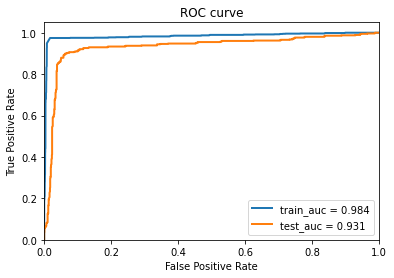

          Accuracy  Specificity  Sensitivity    MCC    PPV    NPV
Training      0.98        0.988        0.960  0.950  0.967  0.985
Test          0.93        0.950        0.872  0.819  0.861  0.954


In [9]:
# SVM 
lksvc_model = SVC(kernel = best_kernel,C = best_c,gamma = best_gamma)
plt.figure()
df_lksvc, tr_predsc, tr_predlabel, te_predsc, te_predlabel = model_evaluation_result(train_X,train_Y,test_X,test_Y,
                                                                                   lksvc_model,'train','test')
plt.show()
print(df_lksvc.round(3))

In [10]:
#cv可設定要多少fold  #scoring可設定'f1_macro'、'recall_macro'、'precision_macro'、'accuracy'...
#scoring參數可參考:https://scikit-learn.org/stable/modules/model_evaluation.html
def confusion_matrix_scorer(clf, X, y):
    y_pred = clf.predict(X)
    cm = confusion_matrix(y, y_pred)
    return {'tn': cm[0, 0], 'fp': cm[0, 1],'fn': cm[1, 0], 'tp': cm[1, 1]}

cv_results = cross_validate(lksvc_model, train_X, train_Y, cv = 5, scoring = confusion_matrix_scorer)
tn = round(cv_results['test_tn'].mean())
fp = round(cv_results['test_fp'].mean())
fn = round(cv_results['test_fn'].mean())
tp = round(cv_results['test_tp'].mean())
accuracy = (tp+tn)/(tn+fp+fn+tp)
precision = tp/(tp+fp)
sensitivity = tp/(tp+fn)
specificity = tn/(tn+fp)
MCC = ((tp*tn)-(fp*fn))/math.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
print(cv_results['test_tn'], round(cv_results['test_tn'].mean()))
print(cv_results['test_fp'], round(cv_results['test_fp'].mean()))
print(cv_results['test_fn'], round(cv_results['test_fn'].mean()))
print(cv_results['test_tp'], round(cv_results['test_tp'].mean()))
print('Cross Validation accuracy:', accuracy)
print('Cross Validation precision:', precision)
print('Cross Validation sensitivity:', sensitivity)
print('Cross Validation specificity:', specificity)
print('Cross Validation MCC:', MCC)
print('Cross Validation Matrix')
print(np.array([[round(cv_results['test_tp'].mean()), round(cv_results['test_fp'].mean())], 
                [ round(cv_results['test_fn'].mean()), round(cv_results['test_tn'].mean())]]))

[697 690 699 695 703] 697
[26 32 23 27 19] 25
[40 40 29 36 49] 39
[227 227 238 231 218] 228
Cross Validation accuracy: 0.9352881698685541
Cross Validation precision: 0.9011857707509882
Cross Validation sensitivity: 0.8539325842696629
Cross Validation specificity: 0.9653739612188366
Cross Validation MCC: 0.8336264506794526
Cross Validation Matrix
[[228  25]
 [ 39 697]]


In [13]:
#c73,c58,c62 ,c61, d17, d13 ,d10, d15, d9 ,d23 ,d35, c89 ,d34 ,d18, d39

In [14]:
#feature_num = np.array([[9,10 ,13 ,15 ,17 ,18 ,23 ,34 ,35 ,39 ,58 ,61 ,62 ,73 ,89 ]])
